参考:
http://13mzawa2.hateblo.jp/entry/2018/03/02/000901

In [1]:
# tensorflowのロード
import tensorflow as tf
import numpy as np

In [2]:
# MNISTデータのダウンロード
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# 補助関数の定義
# 1次元ベクトル化
def tensor_to_vector(input):
    shape = input.get_shape()[1:].as_list()
    dim = np.prod(shape)
    return tf.reshape(input, [-1, dim]), dim

# leaky ReLU活性化関数
def leaky_relu(input):
    return tf.maximum(0.2*input, input)

In [4]:
# DCGANクラスの定義
class DCGAN():
    def __init__(
            self,
            batch_size=100,
            image_shape=[28,28,1],
            dim_z=100,
            dim_W1=1024,
            dim_W2=128,
            dim_W3=64,
            dim_ch=1,
            ):
        # クラス内変数の初期化
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_ch = dim_ch
        # TensorFlow内学習係数の定義
        ## Generator
        self.g_W1 = tf.Variable(tf.random_normal([dim_z, dim_W1], stddev=0.02), name="g_W1")
        self.g_b1 = tf.Variable(tf.random_normal([dim_W1], stddev=0.02), name="g_b1")
        self.g_W2 = tf.Variable(tf.random_normal([dim_W1, dim_W2*7*7], stddev=0.02), name="g_W2")
        self.g_b2 = tf.Variable(tf.random_normal([dim_W2*7*7], stddev=0.02), name="g_b2")
        self.g_W3 = tf.Variable(tf.random_normal([5, 5, dim_W3, dim_W2], stddev=0.02), name="g_W3")
        self.g_b3 = tf.Variable(tf.random_normal([dim_W3], stddev=0.02), name="g_b3")
        self.g_W4 = tf.Variable(tf.random_normal([5, 5, dim_ch, dim_W3], stddev=0.02), name="g_W4")
        self.g_b4 = tf.Variable(tf.random_normal([dim_ch], stddev=0.02), name="g_b4")
        ## Discriminator
        self.d_W1 = tf.Variable(tf.random_normal([5,5,dim_ch,dim_W3], stddev=0.02), name="d_W1")
        self.d_b1 = tf.Variable(tf.random_normal([dim_W3], stddev=0.02), name="d_b1")
        self.d_W2 = tf.Variable(tf.random_normal([5,5,dim_W3,dim_W2], stddev=0.02), name="d_W2")
        self.d_b2 = tf.Variable(tf.random_normal([dim_W2], stddev=0.02), name="d_b2")
        self.d_W3 = tf.Variable(tf.random_normal([dim_W2*7*7,dim_W1], stddev=0.02), name="d_W3")
        self.d_b3 = tf.Variable(tf.random_normal([dim_W1], stddev=0.02), name="d_b3")
        self.d_W4 = tf.Variable(tf.random_normal([dim_W1, 1], stddev=0.02), name="d_W4")
        self.d_b4 = tf.Variable(tf.random_normal([1], stddev=0.02), name="d_b4")
        
    def build_model(self):
        # プレースホルダーの用意
        Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z])  # Generatorへの入力
        # 画像の用意
        img_real = tf.placeholder(tf.float32, [self.batch_size]+self.image_shape)  # Discriminatorへの入力
        img_gen = self.generate(Z)
        # 出力
        raw_real = self.discriminate(img_real)
        raw_gen = self.discriminate(img_gen)
        # 確率
        p_real = tf.nn.sigmoid(raw_real)
        p_gen = tf.nn.sigmoid(raw_gen)
        # コスト関数の定義
        discrim_cost = tf.reduce_mean(
            -tf.reduce_sum(tf.log(p_real) + \
                           tf.log(tf.ones(self.batch_size, tf.float32) - p_gen), axis=1))
        gen_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_gen), axis=1))
        
        return Z, img_real, discrim_cost, gen_cost, p_real, p_gen
        
    def generate(self, Z):
        # 1層目
        fc1 = tf.matmul(Z, self.g_W1) + self.g_b1
        bm1, bv1 = tf.nn.moments(fc1, axes=[0])
        bn1 = tf.nn.batch_normalization(fc1, bm1, bv1, None, None, 1e-5)
        relu1 = tf.nn.relu(bn1)
        # 2層目
        fc2 = tf.matmul(relu1, self.g_W2) + self.g_b2
        bm2, bv2 = tf.nn.moments(fc2, axes=[0])
        bn2 = tf.nn.batch_normalization(fc2, bm2, bv2, None, None, 1e-5)
        relu2 = tf.nn.relu(bn2)
        # [batch, dim_W2*7*7] -> [batch, 7, 7, dim_W2]
        y2 = tf.reshape(relu2, [self.batch_size, 7,7,self.dim_W2])
        # 3層目
        conv_t1 = tf.nn.conv2d_transpose(y2, self.g_W3, strides=[1,2,2,1],
                                         output_shape=[self.batch_size, 14,14,self.dim_W3]) + self.g_b3
        bm3,bv3 = tf.nn.moments(conv_t1, axes=[0, 1, 2])
        bn3 = tf.nn.batch_normalization(conv_t1, bm3, bv3, None, None, 1e-5)
        relu3 = tf.nn.relu(bn3)
        # 4層目
        conv_t2 = tf.nn.conv2d_transpose(relu3, self.g_W4, strides=[1,2,2,1],
                                         output_shape=[self.batch_size, 28, 28, self.dim_ch]) + self.g_b4
        img = tf.nn.sigmoid(conv_t2)
        
        return img
    
    def discriminate(self, img):
        # 1層目
        conv1 = tf.nn.conv2d(img, self.d_W1, strides=[1,2,2,1], padding="SAME") + self.d_b1
        y1 = leaky_relu(conv1)
        # 2層目
        conv2 = tf.nn.conv2d(y1, self.d_W2, strides=[1,2,2,1], padding="SAME") + self.d_b2
        y2 = leaky_relu(conv2)
        # 3層目
        vec, _ = tensor_to_vector(y2)
        fc1 = tf.matmul(vec, self.d_W3) + self.d_b3
        y3 = leaky_relu(fc1)
        # 4層目
        fc2 = tf.matmul(y3, self.d_W4) + self.d_b4
        #y4 = tf.nn.sigmoid(fc2)
        
        return fc2
    
    def generate_samples(self, batch_size):
        # ここでは指定したbatch_sizeでサンプルを生成するため，self.batch_sizeは使わない
        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z])
        # 1層目
        fc1 = tf.matmul(Z, self.g_W1) + self.g_b1
        bm1, bv1 = tf.nn.moments(fc1, axes=[0])
        bn1 = tf.nn.batch_normalization(fc1, bm1, bv1, None, None, 1e-5)
        relu1 = tf.nn.relu(bn1)
        # 2層目
        fc2 = tf.matmul(relu1, self.g_W2) + self.g_b2
        bm2, bv2 = tf.nn.moments(fc2, axes=[0])
        bn2 = tf.nn.batch_normalization(fc2, bm2, bv2, None, None, 1e-5)
        relu2 = tf.nn.relu(bn2)
        # [batch, dim_W2*7*7] -> [batch, 7, 7, dim_W2]
        y2 = tf.reshape(relu2, [batch_size, 7,7,self.dim_W2])
        # 3層目
        conv_t1 = tf.nn.conv2d_transpose(y2, self.g_W3, strides=[1,2,2,1],
                                         output_shape=[batch_size, 14,14,self.dim_W3]) + self.g_b3
        bm3,bv3 = tf.nn.moments(conv_t1, axes=[0, 1, 2])
        bn3 = tf.nn.batch_normalization(conv_t1, bm3, bv3, None, None, 1e-5)
        relu3 = tf.nn.relu(bn3)
        # 4層目
        conv_t2 = tf.nn.conv2d_transpose(relu3, self.g_W4, strides=[1,2,2,1],
                                         output_shape=[batch_size, 28, 28, self.dim_ch]) + self.g_b4
        img = tf.nn.sigmoid(conv_t2)
        return Z, img

In [5]:
# モデルの構築
dcgan_model = DCGAN(batch_size=128, image_shape=[28,28,1])
Z_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = dcgan_model.build_model()
Z_gen, image_gen = dcgan_model.generate_samples(batch_size=32)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# セッション開始
sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=10)

In [7]:
# tensorflow変数の準備
discrim_vars = [x for x in tf.trainable_variables() if "d_" in x.name]
gen_vars = [x for x in tf.trainable_variables() if "g_" in x.name]
# 最適化メソッドの用意
optimizer_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(d_cost_tf, var_list=discrim_vars)
optimizer_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(g_cost_tf, var_list=gen_vars)


Instructions for updating:
Use tf.cast instead.


In [8]:
# TensorFlow内のグローバル変数の初期化
tf.global_variables_initializer().run()

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

# 生成画像の可視化
def visualize(images, num_itr, rows, cols):
    # タイトル表示
    plt.title(num_itr, color="red")
    for index, data in enumerate(images):
        # 画像データはrows * colsの行列上に配置
        plt.subplot(rows, cols, index + 1)
        # 軸表示は無効
        plt.axis("off")
        # データをグレースケール画像として表示
        plt.imshow(data.reshape(28,28), cmap="gray", interpolation="nearest")
    plt.show()

In [10]:
# 学習
def train(train_imgs, n_epochs, batch_size):
    itr = 0
    for epoch in range(n_epochs):
        index = np.arange(len(train_imgs))
        np.random.shuffle(index)
        trX = train_imgs[index]
        
        # batch_size毎のfor
        for start, end in zip(
                range(0, len(trX), batch_size),
                range(batch_size, len(trX), batch_size)):
            # 画像は0-1に正規化
            Xs = trX[start:end].reshape([-1, 28,28,1]) / 255.
            Zs = np.random.uniform(-1,1, size=[batch_size, dcgan_model.dim_z]).astype(np.float32)
            
            if np.mod(itr, 2) != 0 :
                # 偶数番目はGeneratorを学習
                _, gen_loss_val = sess.run([optimizer_g, g_cost_tf], feed_dict={Z_tf:Zs})
                discrim_loss_val, p_real_val, p_gen_val \
                        = sess.run([d_cost_tf, p_real, p_gen], feed_dict={Z_tf:Zs, image_tf:Xs})
                #print("=========== updating G ==========")
                #print("iteration:", itr)
                #print("gen loss:", gen_loss_val)
                #print("discrim loss:", discrim_loss_val)
            else:
                # 奇数番目はDiscriminatorを学習
                _, discrim_loss_val = sess.run([optimizer_d, d_cost_tf],
                                               feed_dict={Z_tf:Zs, image_tf:Xs})
                gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen], 
                                                               feed_dict={Z_tf:Zs, image_tf:Xs})
                #print("=========== updating D ==========")
                #print("iteration:", itr)
                #print("gen loss:", gen_loss_val)
                #print("discrim loss:", discrim_loss_val)
                
            
            #print("Average P(real)=", p_real_val.mean())
            #print("Average P(gen)=", p_gen_val.mean())
            itr += 1
        
        # サンプルを表示
        z = np.random.uniform(-1,1, size=[32, dcgan_model.dim_z]).astype(np.float32)
        generated_samples = sess.run([image_gen], feed_dict={Z_gen:z})
        #plt.imshow(generated_samples[0][0].reshape(28,28), cmap="gray", interpolation="nearest")
        visualize(generated_samples[0], epoch, 4,8)
        print("epoch = ", epoch)

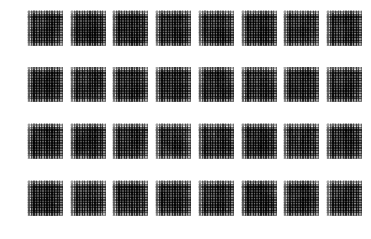

epoch =  0


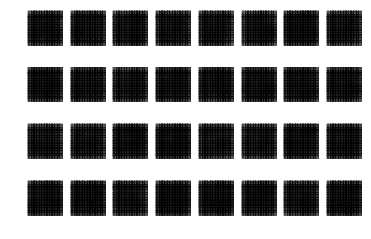

epoch =  1


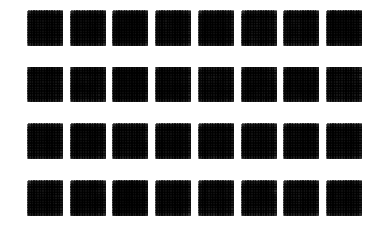

epoch =  2


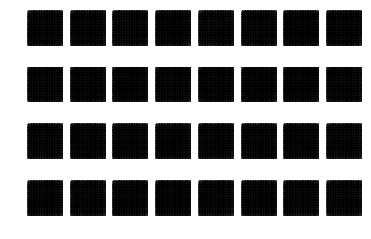

epoch =  3


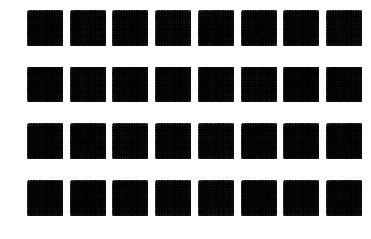

epoch =  4


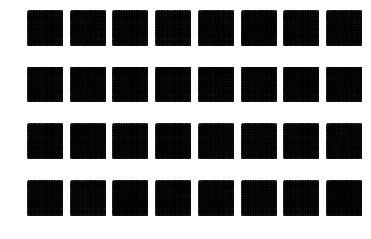

epoch =  5


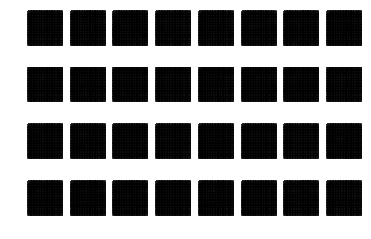

epoch =  6


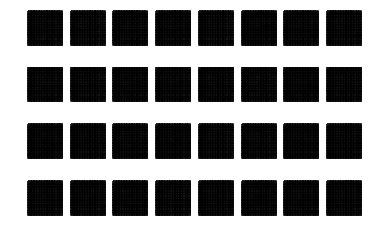

epoch =  7


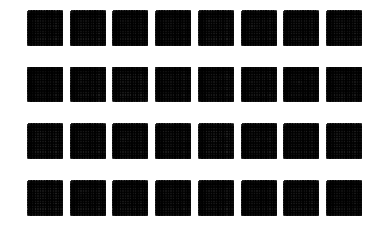

epoch =  8


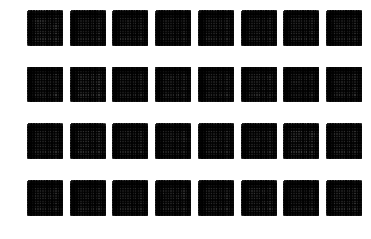

epoch =  9


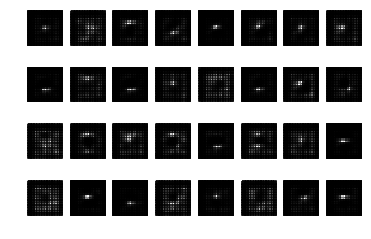

epoch =  10


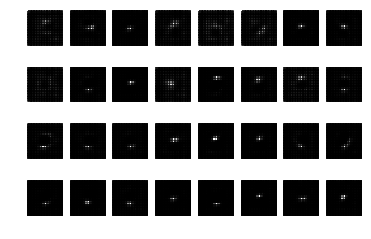

epoch =  11


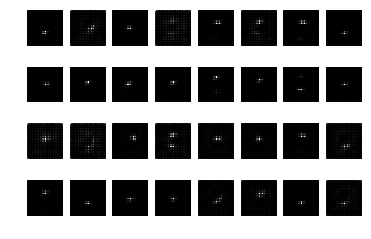

epoch =  12


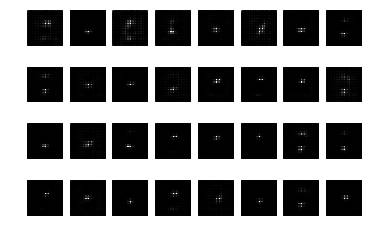

epoch =  13


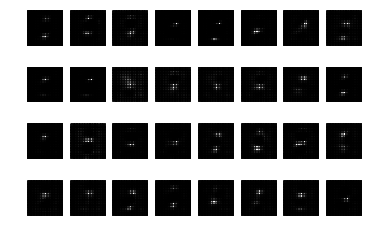

epoch =  14


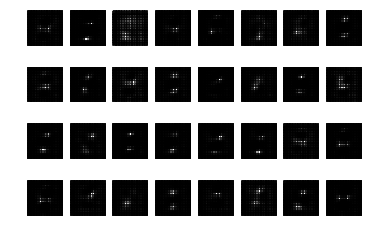

epoch =  15


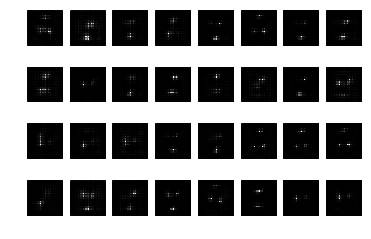

epoch =  16


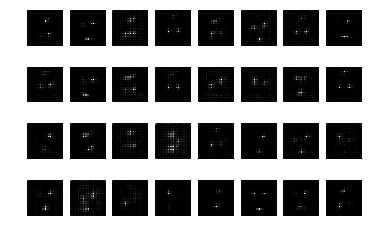

epoch =  17


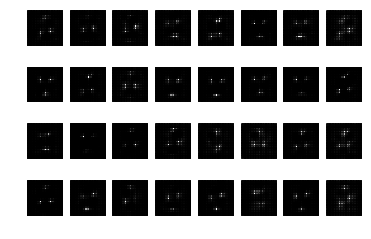

epoch =  18


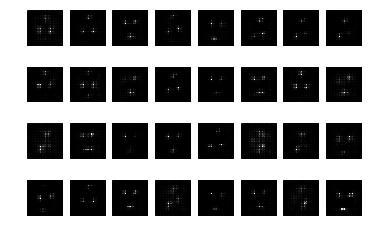

epoch =  19


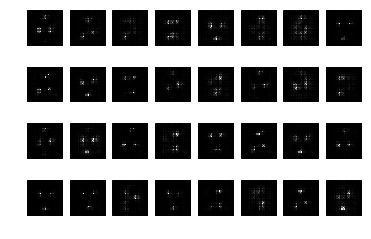

epoch =  20


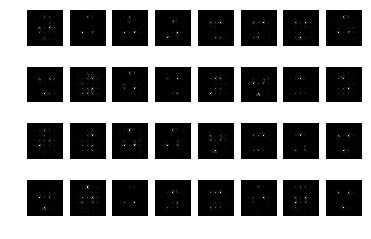

epoch =  21


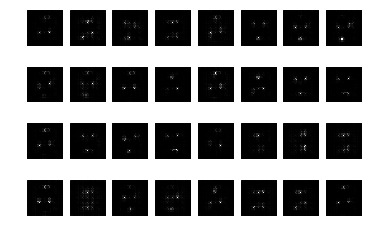

epoch =  22


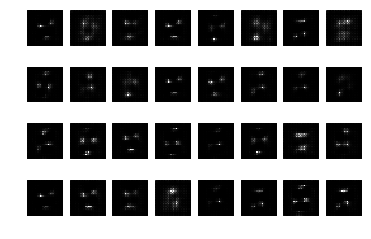

epoch =  23


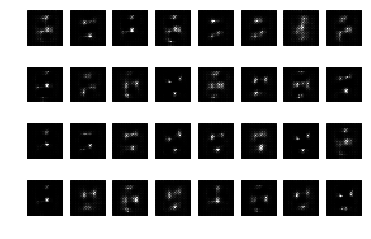

epoch =  24


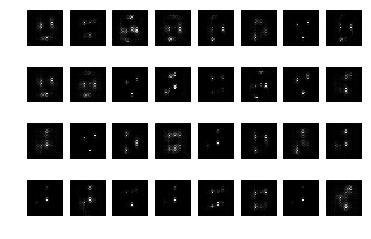

epoch =  25


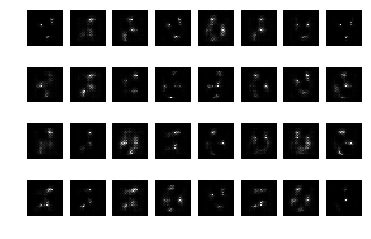

epoch =  26


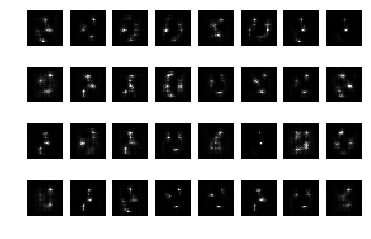

epoch =  27


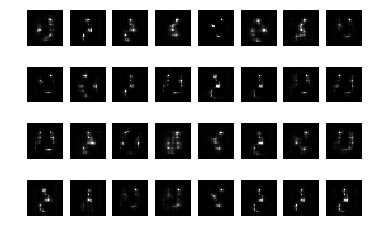

epoch =  28


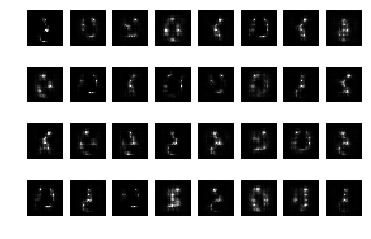

epoch =  29


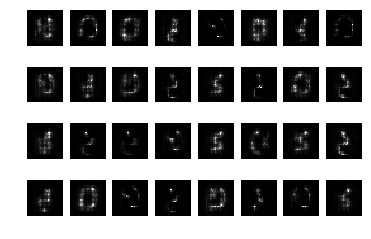

epoch =  30


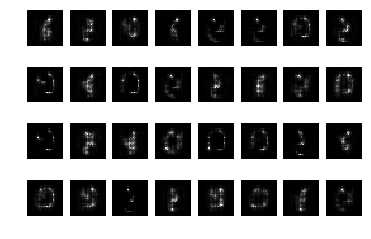

epoch =  31


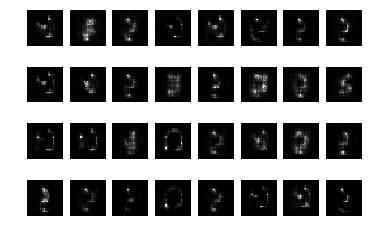

epoch =  32


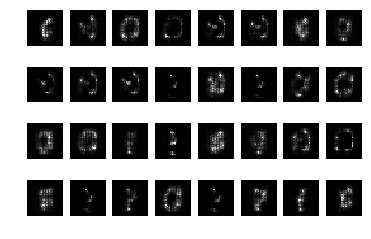

epoch =  33


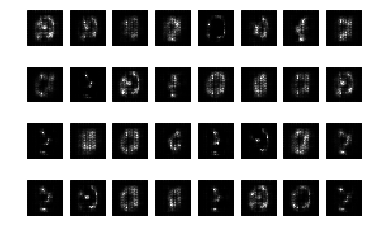

epoch =  34


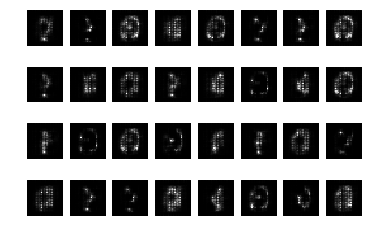

epoch =  35


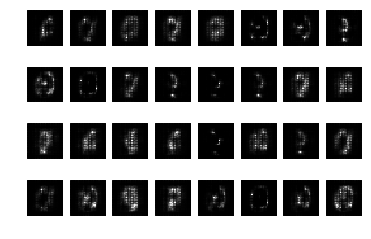

epoch =  36


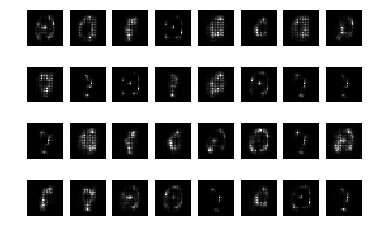

epoch =  37


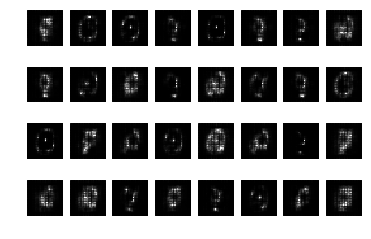

epoch =  38


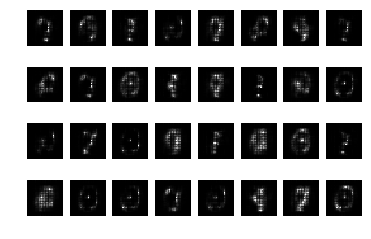

epoch =  39


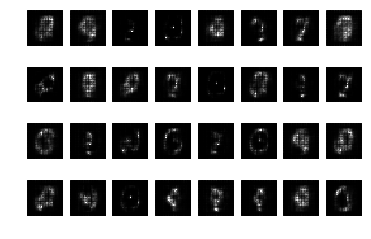

epoch =  40


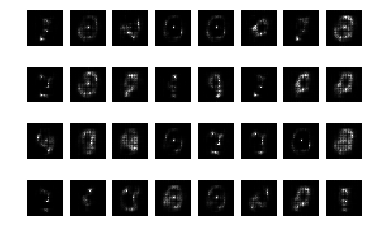

epoch =  41


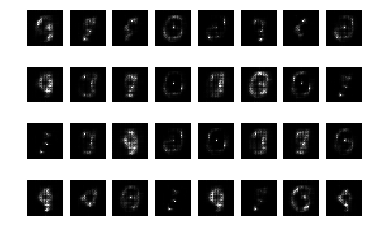

epoch =  42


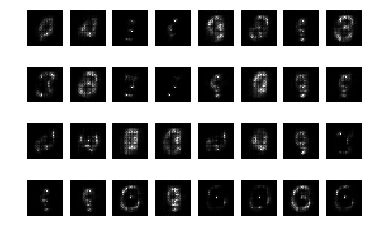

epoch =  43


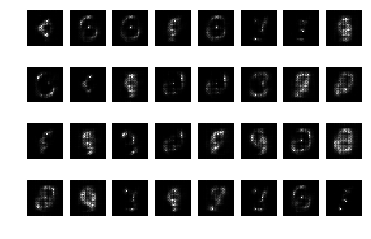

epoch =  44


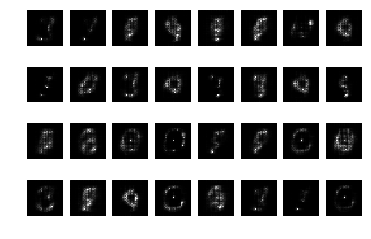

epoch =  45


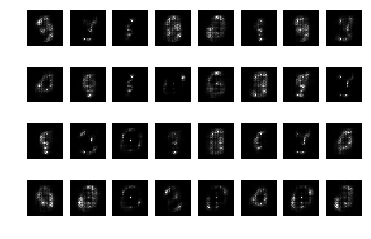

epoch =  46


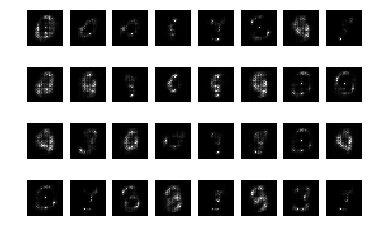

epoch =  47


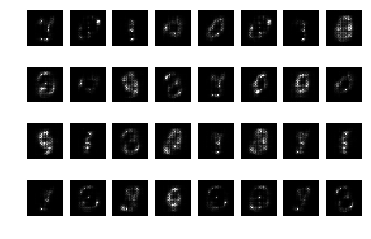

epoch =  48


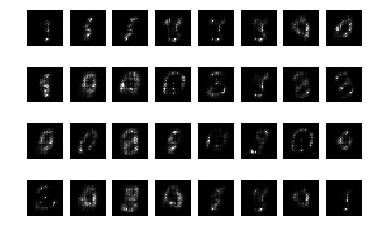

epoch =  49


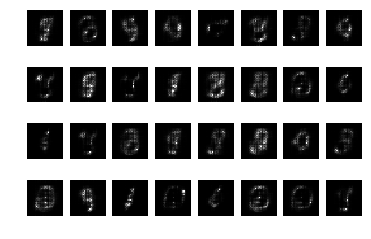

epoch =  50


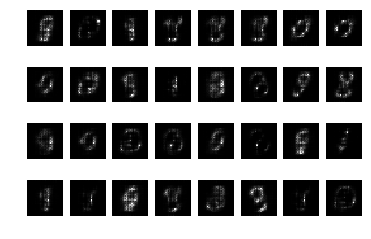

epoch =  51


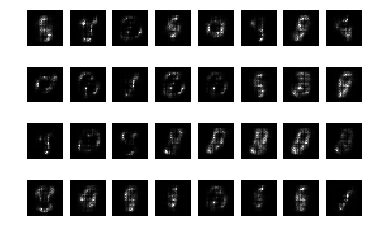

epoch =  52


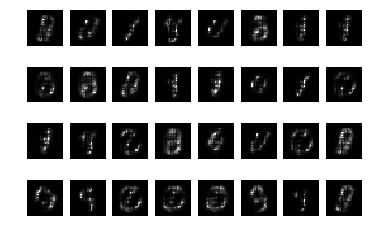

epoch =  53


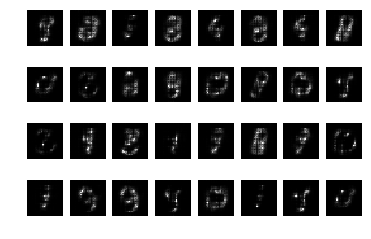

epoch =  54


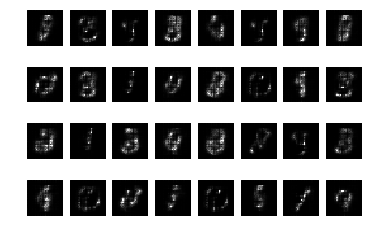

epoch =  55


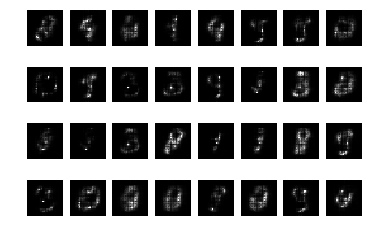

epoch =  56


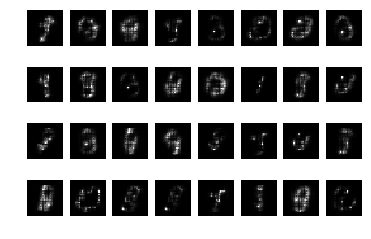

epoch =  57


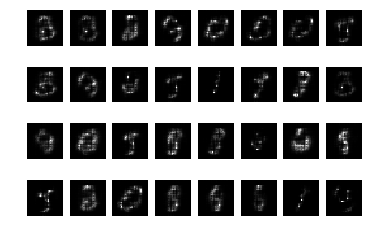

epoch =  58


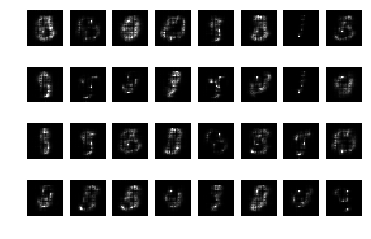

epoch =  59


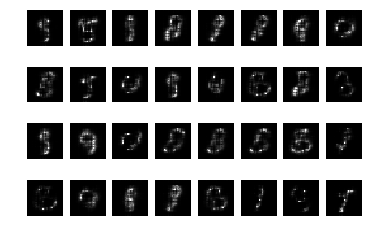

epoch =  60


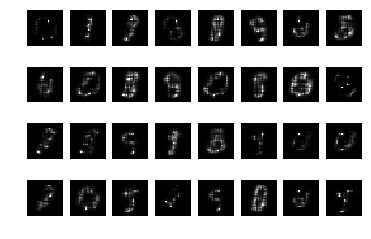

epoch =  61


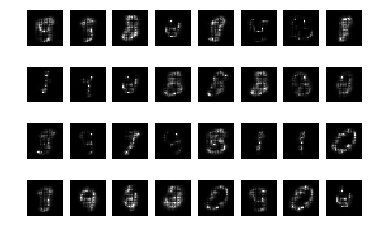

epoch =  62


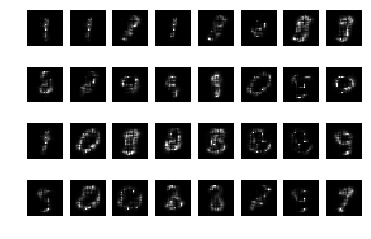

epoch =  63


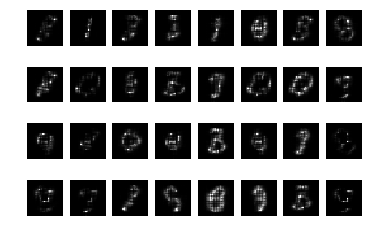

epoch =  64


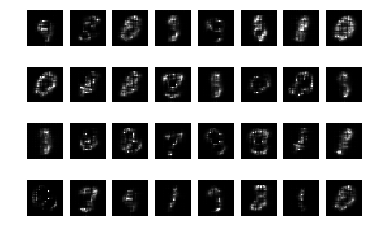

epoch =  65


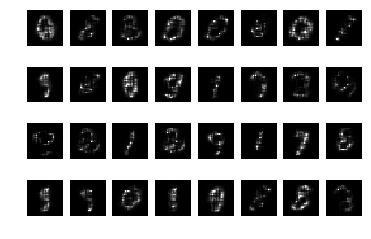

epoch =  66


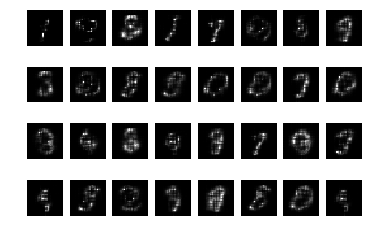

epoch =  67


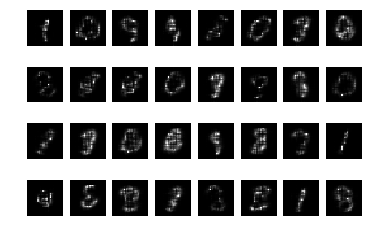

epoch =  68


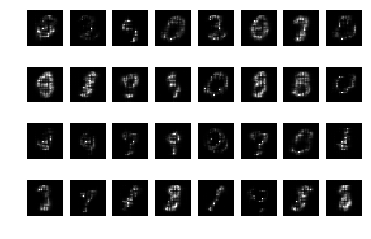

epoch =  69


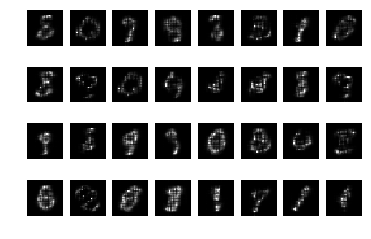

epoch =  70


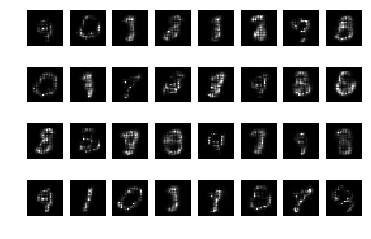

epoch =  71


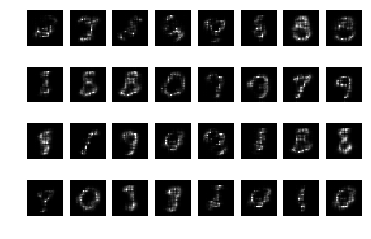

epoch =  72


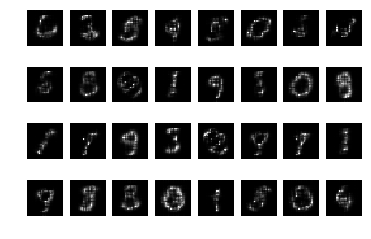

epoch =  73


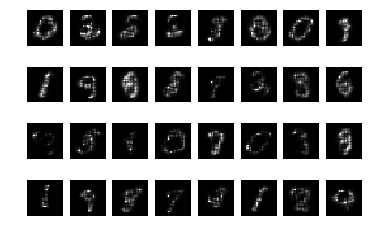

epoch =  74


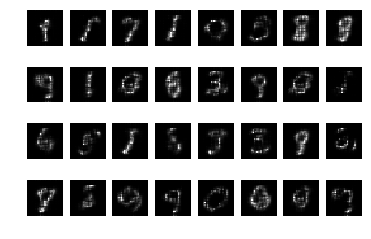

epoch =  75


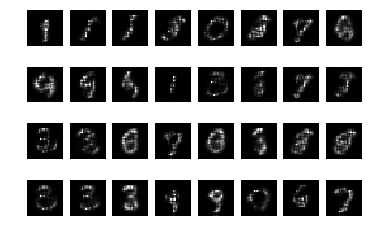

epoch =  76


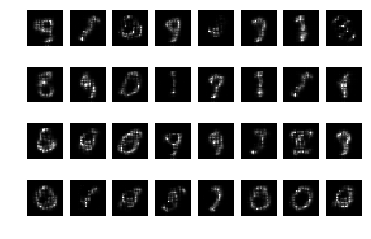

epoch =  77


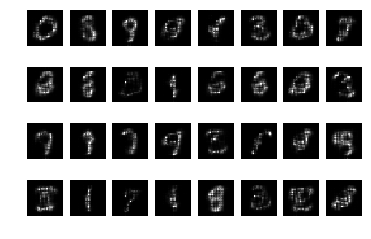

epoch =  78


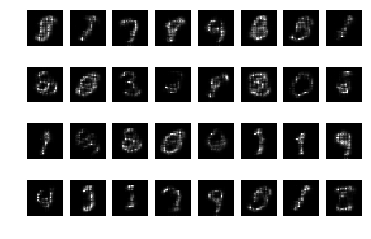

epoch =  79


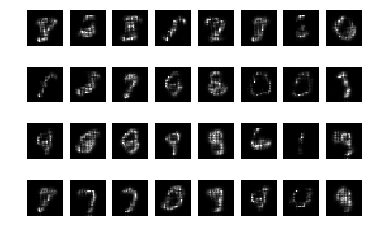

epoch =  80


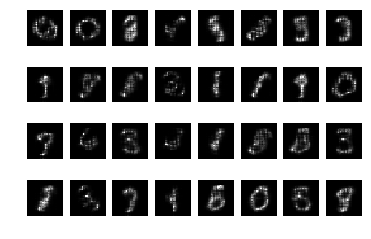

epoch =  81


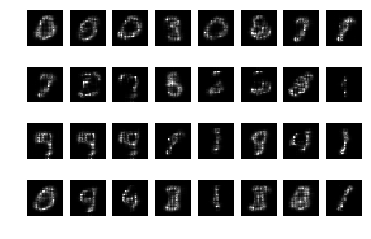

epoch =  82


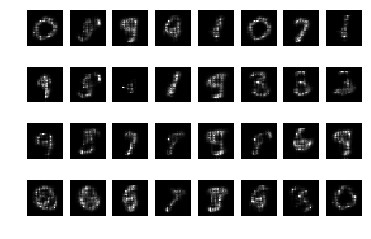

epoch =  83


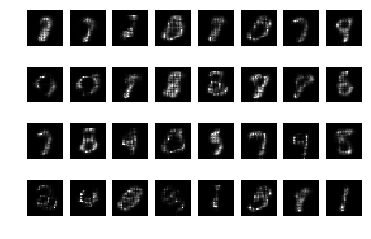

epoch =  84


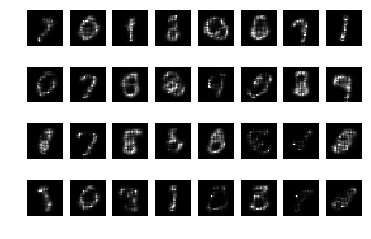

epoch =  85


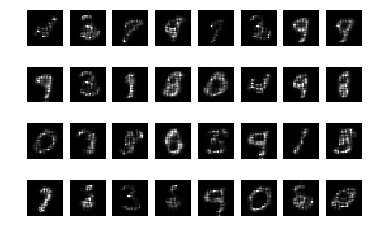

epoch =  86


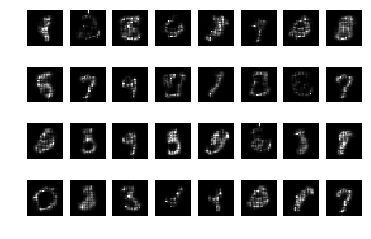

epoch =  87


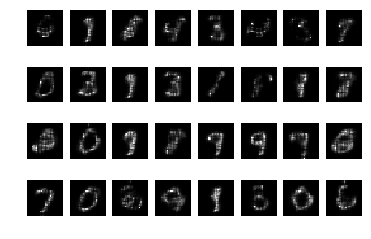

epoch =  88


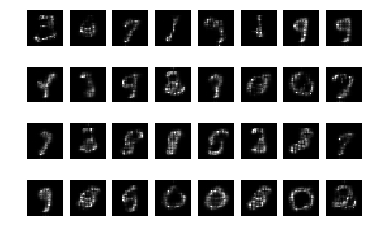

epoch =  89


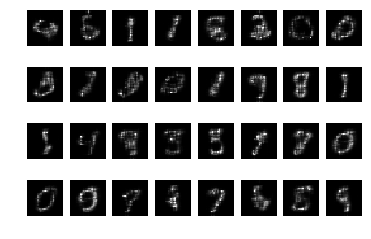

epoch =  90


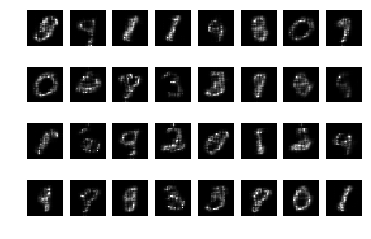

epoch =  91


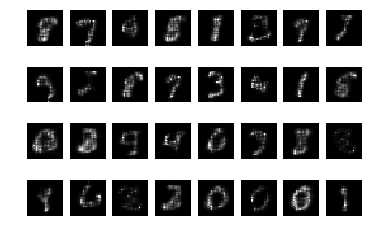

epoch =  92


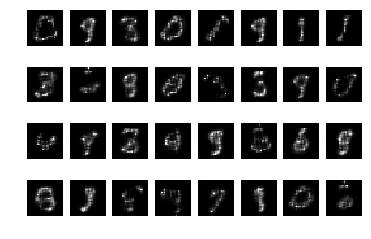

epoch =  93


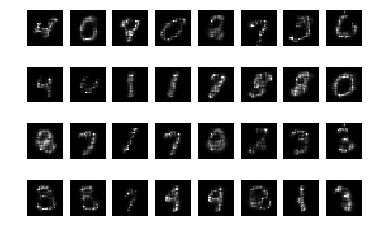

epoch =  94


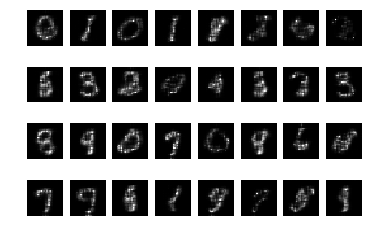

epoch =  95


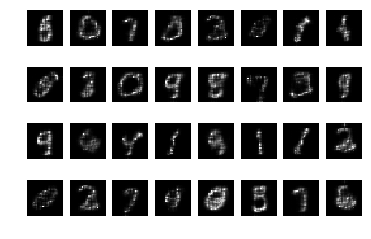

epoch =  96


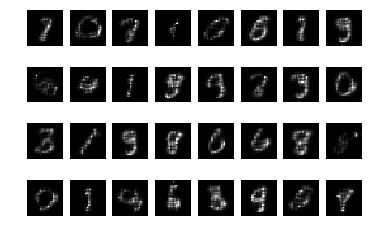

epoch =  97


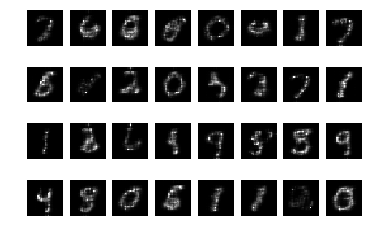

epoch =  98


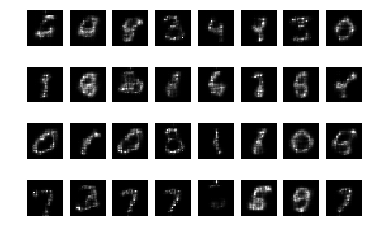

epoch =  99


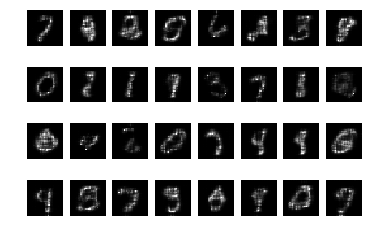

epoch =  100


In [11]:
train(mnist.test.images, 101, 128)